In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Introduction

Hospital Readmission is a bad business for both the hospital and the patient. CMS created many programs such as Hospital Readmission Reduction Program that reduces reimbursement to hospitals with above average readmissions. And patient's experience gets worse with readmission.

A hospital can then create an algorithm to identify patients with increased risk of readmission, and provide more attentive care to these people. So how can these patients be identified. Machine learning can be leverage in this case.

One patient population with an increased risk of readmission are people with diabetes. In this project, I will focus on predicting hospital readmission for patients with diabetes.

# Problem

Predict if a patient with diabetes will be readmitted or not. This is a supervised learning, or more specifically a classification problem.

The dataset comes from the UCI repository. It consists of 100,000 hospital admisions from patients with diaabetes between 1999 and 2008.

In [4]:
data_folder = Path('../data')
data = data_folder / 'diabetic_data.csv'
df = pd.read_csv(data)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [83]:
mapping    = data_folder / 'IDs_mapping.xlsx'
adm_type   = pd.read_excel(mapping, sheet_name='admission_type_id')
discharge  = pd.read_excel(mapping, sheet_name='discharge_disposition_id')
adm_source = pd.read_excel(mapping, sheet_name='admission_source_id')

In [6]:
len(df)

101766

In [7]:
df.dtypes.value_counts()

object    37
int64     13
dtype: int64

We have 101,766 patients and 50 columns in this dataset: 37 of which are texts, and 13 are numeric.

In [10]:
list(df.columns)

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

In [11]:
df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [12]:
df.describe(include='all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,1.017660e+05,1.017660e+05,101766,101766,101766,101766,101766.000000,101766.000000,101766.000000,101766.000000,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,6,3,10,10,NaN,NaN,NaN,NaN,...,1,4,4,2,2,2,2,2,2,3
top,NaN,NaN,Caucasian,Female,[70-80),?,NaN,NaN,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
freq,NaN,NaN,76099,54708,26068,98569,NaN,NaN,NaN,NaN,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864
mean,1.652016e+08,5.433040e+07,NaN,NaN,NaN,NaN,2.024006,3.715642,5.754437,4.395987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.026403e+08,3.869636e+07,NaN,NaN,NaN,NaN,1.445403,5.280166,4.064081,2.985108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.496119e+07,2.341322e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.523890e+08,4.550514e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.302709e+08,8.754595e+07,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
df_clean = df.copy()
df_clean['readmitted'] = (df['readmitted']=='<30').astype(int)

In [21]:
df_clean['readmitted'].value_counts(normalize=True)

0    0.888401
1    0.111599
Name: readmitted, dtype: float64

**=> class imbalance**

In [16]:
df_clean['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [85]:
df_clean.replace({'?':np.nan}, inplace=True)

In [19]:
pd.crosstab(df_clean['race'], df_clean['readmitted'])

readmitted,0,1
race,,
AfricanAmerican,17055,2155
Asian,576,65
Caucasian,67507,8592
Hispanic,1825,212
Other,1361,145


In [17]:
df_clean['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [20]:
pd.crosstab(df_clean['gender'], df_clean['readmitted'])

readmitted,0,1
gender,,
Female,48556,6152
Male,41850,5205
Unknown/Invalid,3,0


In [18]:
df_clean['age'].value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [34]:
age = pd.crosstab(df_clean['age'], df_clean['readmitted'], normalize='index')
age

readmitted,0,1
age,,
[0-10),0.981366,0.018634
[10-20),0.942113,0.057887
[20-30),0.857574,0.142426
[30-40),0.887682,0.112318
[40-50),0.893960,0.106040
[50-60),0.903338,0.096662
[60-70),0.888716,0.111284
[70-80),0.882269,0.117731
[80-90),0.879165,0.120835


In [86]:
df_clean['admission_type_id'] = df_clean['admission_type_id'].replace({1:'Emergency',2:'Urgent',3:'Elective',
                                                                       4:'Newborn',5:'Unknown',6:'Unknown',7:'Trauma Center',8:'Unknown'})

In [36]:
pd.crosstab(df_clean['admission_type_id'], df_clean['readmitted'], normalize='index')

readmitted,0,1
admission_type_id,,
Elective,0.896073,0.103927
Emergency,0.884775,0.115225
Newborn,0.900000,0.100000
Trauma Center,1.000000,0.000000
Unknown,0.893421,0.106579
Urgent,0.888203,0.111797


In [39]:
df_clean.groupby('readmitted')['num_lab_procedures'].describe()

,count,mean,std,min,25%,50%,75%,max
readmitted,,,,,,,,
0,90409.0,42.953644,19.719348,1.0,31.0,44.0,57.0,129.0
1,11357.0,44.226028,19.276087,1.0,33.0,45.0,58.0,132.0


In [41]:
df_clean.groupby('readmitted')['num_procedures'].describe()

,count,mean,std,min,25%,50%,75%,max
readmitted,,,,,,,,
0,90409.0,1.347123,1.714242,0.0,0.0,1.0,2.0,6.0
1,11357.0,1.280884,1.635992,0.0,0.0,1.0,2.0,6.0


In [60]:
numeric_feat = ['time_in_hospital', 'num_lab_procedures',
               'num_procedures', 'num_medications', 'number_outpatient',
               'number_emergency', 'number_inpatient', 'number_diagnoses']

In [64]:
cat_feat = [col for col in df_clean if col not in (numeric_feat + ['encounter_id','patient_nbr', 'readmitted'])]

In [87]:
dis_dispo = dict(zip(discharge['discharge_disposition_id'], discharge['description']))

In [88]:
admission = dict(zip(adm_source['admission_source_id'], adm_source['description']))

In [89]:
df_clean['discharge_disposition_id'].replace(dis_dispo, inplace=True)

In [90]:
df_clean['admission_source_id'].replace(admission, inplace=True)

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [96]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_feat),
        ('cat', categorical_transformer, categorical_feat)
    ]
)

In [97]:
target = df_clean['readmitted'].values
features = df[numeric_feat + cat_feat].copy()

In [99]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

seed = 11
X_train, X_test, y_train, y_test = train_test_split(features, target,
                        test_size=0.2, random_state=seed, stratify=target)

In [100]:
kfold = KFold(n_splits=10, random_state=seed)

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=20))
])

scoring = 'accuracy'
scores = cross_val_score(pipe, X_train, y_train, cv=kfold,
                        scoring=scoring)
print(f"10-fold cross validation average accuracy: {scores.mean():,.3f}")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: F

10-fold cross validation average accuracy: 0.888


# Precision and recall

In [102]:
from sklearn.metrics import classification_report

pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.42      0.01      0.02      2271

    accuracy                           0.89     20354
   macro avg       0.66      0.50      0.48     20354
weighted avg       0.84      0.89      0.84     20354



Text(0.5, 1, 'Random Forest')

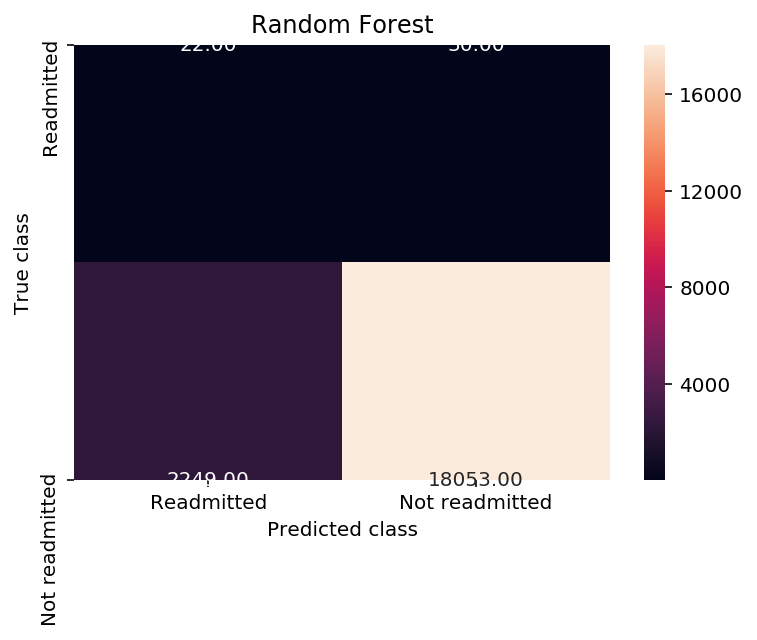

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = pipe.predict(X_test)
forest_cm = confusion_matrix(y_pred, y_test, [1,0])
sns.heatmap(forest_cm, annot=True, fmt='.2f',xticklabels = ["Readmitted", "Not readmitted"] , yticklabels = ["Readmitted", "Not readmitted"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')

# The ROC Curve

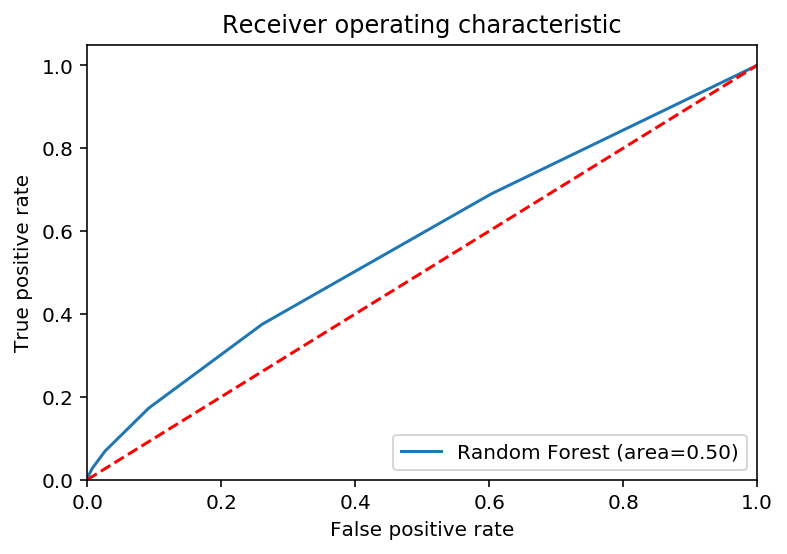

In [105]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

rf_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (area={rf_roc_auc:,.2f})')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')

# Feature Importance